In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
def delete_index(T, index):
    return torch.cat([T[:i], T[i+1:]])

In [5]:
class MomentumObject:
    def __init__(self, w, h):
        self.w, self.h = w,h
        self.position = np.array([w/2, h/2])
        self.blank_state = np.zeros((w,h))
        self.speed = np.random.randint(-2, 2, size=2)
    def _jump_bound(self, position):
        if position[0] >= self.w:
            position[0] = position[0] - self.w
        elif position[0] < 0:
            position[0] = self.w + position[0]
        if position[1] >= self.h:
            position[1] = position[1] - self.w
        elif position[1] < 0:
            position[1] = self.h + position[1]
    def get_state_action(self):
        return np.concatenate((self.position, self.speed))
    def step(self):
        self.position += self.speed
        self._jump_bound(self.position)
        self.speed = np.random.randint(-2, 2, size=2)
    def render(self, predict_position=None):
        state = self.blank_state.copy()
        position = np.round(self.position).astype(int)
        state[position[0], position[1]] = 1
        if predict_position is not None:
            pred_x = np.round(predict_position[0]*(self.w-1)).astype(int)
            pred_y = np.round(predict_position[1]*(self.h-1)).astype(int)
            state[pred_x, pred_y] = 0.2
        return state
w,h=10,10
momentum_object = MomentumObject(w, h)
momentum_object.render()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
num_buffer = 64
dimension_state = 2
num_state = momentum_object.position.shape[0] + momentum_object.speed.shape[0]
states_actions = torch.zeros((num_buffer, num_state))

def update_state_buffer(states_actions, remove_index=None):
    new_state_action = torch.unsqueeze(torch.tensor(momentum_object.get_state_action()), 0)
    if remove_index is None:
        states_actions = states_actions[:-1]
    else:
        states_actions = delete_index(states_actions, remove_index)
    return torch.cat((new_state_action, states_actions))
for i in range(num_buffer):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions)
states_actions

tensor([[ 2.,  1.,  1., -1.],
        [ 4.,  2., -2., -1.],
        [ 6.,  4., -2., -2.],
        [ 8.,  3., -2.,  1.],
        [ 7.,  4.,  1., -1.],
        [ 8.,  6., -1., -2.],
        [ 0.,  6., -2.,  0.],
        [ 2.,  6., -2.,  0.],
        [ 4.,  8., -2., -2.],
        [ 4.,  8.,  0.,  0.],
        [ 4.,  7.,  0.,  1.],
        [ 3.,  8.,  1., -1.],
        [ 2.,  0.,  1., -2.],
        [ 1.,  9.,  1.,  1.],
        [ 1.,  0.,  0., -1.],
        [ 2.,  1., -1., -1.],
        [ 1.,  3.,  1., -2.],
        [ 3.,  5., -2., -2.],
        [ 5.,  6., -2., -1.],
        [ 6.,  8., -1., -2.],
        [ 8.,  0., -2., -2.],
        [ 8.,  1.,  0., -1.],
        [ 0.,  2., -2., -1.],
        [ 1.,  3., -1., -1.],
        [ 0.,  2.,  1.,  1.],
        [ 2.,  4., -2., -2.],
        [ 1.,  4.,  1.,  0.],
        [ 3.,  4., -2.,  0.],
        [ 4.,  3., -1.,  1.],
        [ 3.,  3.,  1.,  0.],
        [ 4.,  2., -1.,  1.],
        [ 4.,  2.,  0.,  0.],
        [ 4.,  2.,  0.,  0.],
        [ 

In [24]:
def train(i, encoder, states_actions, optimizer_encoder):
    encoder.train()
    states_actions = states_actions.to(device)
    optimizer_encoder.zero_grad()
    
    current_state_action = torch.clone(states_actions[1:]).to(device).to(device)
    next_state = torch.clone(states_actions[:-1, :2]).to(device)
    current_state = current_state_action[:,:2]
    current_action = current_state_action[:,2:]
    
    _current_state = encoder(current_state)
    _next_state = encoder(next_state)
    
    _current_state_action = torch.cat((_current_state, current_action), axis=1)
    _next_state_predict = predictor(_current_state_action)
    
    __current_state  = decoder(_current_state)
    __next_state = decoder(_next_state)
    
    loss = mse_loss(_next_state_predict, _next_state) + \
            mse_loss(__current_state, current_state) + \
            mse_loss(__next_state, next_state)
    print("loss[", i,"]:", loss.mean())
    
    loss.mean().backward()
    optimizer_encoder.step()
    
    return torch.argmin(loss.mean(axis=1)).type(torch.int)
    
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = nn.Sequential(
                nn.Linear(2,4),
                nn.ReLU(),
                nn.Linear(4,2),
                nn.Sigmoid()).to(device).to(torch.float64)
decoder = nn.Sequential(
                nn.Linear(2,4),
                nn.ReLU(),
                nn.Linear(4,2),
                nn.Sigmoid()).to(device).to(torch.float64)
predictor = nn.Sequential(
                nn.Linear(4,16),
                nn.ReLU(),
                nn.Linear(16,32),
                nn.ReLU(),
                nn.Linear(32,8),
                nn.ReLU(),
                nn.Linear(8,2),
                nn.Sigmoid()).to(device).to(torch.float64)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)
mse_loss = nn.MSELoss(reduction='none')

lowest_loss_index = None
for i in range(1000):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions, lowest_loss_index)
    lowest_loss_index = train(i, encoder, states_actions, optimizer_encoder)


loss[ 0 ]: tensor(43.0607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 1 ]: tensor(43.0707, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 2 ]: tensor(43.0443, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 3 ]: tensor(43.0556, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 4 ]: tensor(43.0047, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 5 ]: tensor(43.0248, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 6 ]: tensor(43.0536, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 7 ]: tensor(43.1228, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 8 ]: tensor(43.1565, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 9 ]: tensor(43.1488, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 10 ]: tensor(43.1187, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 11 

loss[ 91 ]: tensor(44.0676, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 92 ]: tensor(44.0545, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 93 ]: tensor(44.0480, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 94 ]: tensor(44.0415, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 95 ]: tensor(44.0083, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 96 ]: tensor(43.9644, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 97 ]: tensor(43.9204, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 98 ]: tensor(43.9175, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 99 ]: tensor(43.8944, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 100 ]: tensor(43.8821, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 101 ]: tensor(43.8786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0

loss[ 188 ]: tensor(44.1558, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 189 ]: tensor(44.1943, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 190 ]: tensor(44.2342, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 191 ]: tensor(44.2592, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 192 ]: tensor(44.2768, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 193 ]: tensor(44.2984, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 194 ]: tensor(44.3154, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 195 ]: tensor(44.3245, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 196 ]: tensor(44.3338, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 197 ]: tensor(44.3147, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 198 ]: tensor(44.3592, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 284 ]: tensor(44.8725, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 285 ]: tensor(44.9280, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 286 ]: tensor(44.9704, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 287 ]: tensor(44.9752, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 288 ]: tensor(44.9561, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 289 ]: tensor(45.0025, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 290 ]: tensor(45.0661, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 291 ]: tensor(45.0765, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 292 ]: tensor(45.0558, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 293 ]: tensor(45.0080, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 294 ]: tensor(44.9379, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 378 ]: tensor(44.8827, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 379 ]: tensor(44.8593, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 380 ]: tensor(44.7629, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 381 ]: tensor(44.7098, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 382 ]: tensor(44.6696, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 383 ]: tensor(44.6199, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 384 ]: tensor(44.5506, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 385 ]: tensor(44.5514, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 386 ]: tensor(44.5829, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 387 ]: tensor(44.6455, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 388 ]: tensor(44.6774, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 472 ]: tensor(45.2107, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 473 ]: tensor(45.1447, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 474 ]: tensor(45.0801, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 475 ]: tensor(45.1153, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 476 ]: tensor(45.1710, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 477 ]: tensor(45.1688, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 478 ]: tensor(45.1699, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 479 ]: tensor(45.2178, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 480 ]: tensor(45.2773, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 481 ]: tensor(45.2979, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 482 ]: tensor(45.2943, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 572 ]: tensor(45.2797, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 573 ]: tensor(45.2771, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 574 ]: tensor(45.2918, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 575 ]: tensor(45.3030, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 576 ]: tensor(45.3112, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 577 ]: tensor(45.2898, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 578 ]: tensor(45.2432, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 579 ]: tensor(45.1787, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 580 ]: tensor(45.1288, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 581 ]: tensor(45.0897, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 582 ]: tensor(45.1044, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 672 ]: tensor(44.6157, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 673 ]: tensor(44.5497, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 674 ]: tensor(44.5563, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 675 ]: tensor(44.4846, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 676 ]: tensor(44.4894, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 677 ]: tensor(44.4976, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 678 ]: tensor(44.5010, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 679 ]: tensor(44.5352, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 680 ]: tensor(44.5843, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 681 ]: tensor(44.6467, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 682 ]: tensor(44.7034, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 772 ]: tensor(44.6593, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 773 ]: tensor(44.7742, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 774 ]: tensor(44.8891, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 775 ]: tensor(44.9738, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 776 ]: tensor(45.0193, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 777 ]: tensor(45.0231, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 778 ]: tensor(45.0251, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 779 ]: tensor(45.0048, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 780 ]: tensor(44.9893, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 781 ]: tensor(44.9696, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 782 ]: tensor(44.9596, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 872 ]: tensor(45.9918, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 873 ]: tensor(45.9994, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 874 ]: tensor(46.0554, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 875 ]: tensor(46.0967, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 876 ]: tensor(46.1029, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 877 ]: tensor(46.1509, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 878 ]: tensor(46.1807, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 879 ]: tensor(46.1653, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 880 ]: tensor(46.0986, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 881 ]: tensor(45.9934, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 882 ]: tensor(45.8709, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

loss[ 972 ]: tensor(45.8428, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 973 ]: tensor(45.8510, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 974 ]: tensor(45.8475, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 975 ]: tensor(45.8697, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 976 ]: tensor(45.8888, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 977 ]: tensor(45.8935, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 978 ]: tensor(45.9065, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 979 ]: tensor(45.8806, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 980 ]: tensor(45.8917, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 981 ]: tensor(45.9064, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
loss[ 982 ]: tensor(45.9148, device='cuda:0', dtype=torch.float64, grad_fn=<Mean

<IPython.core.display.Javascript object>


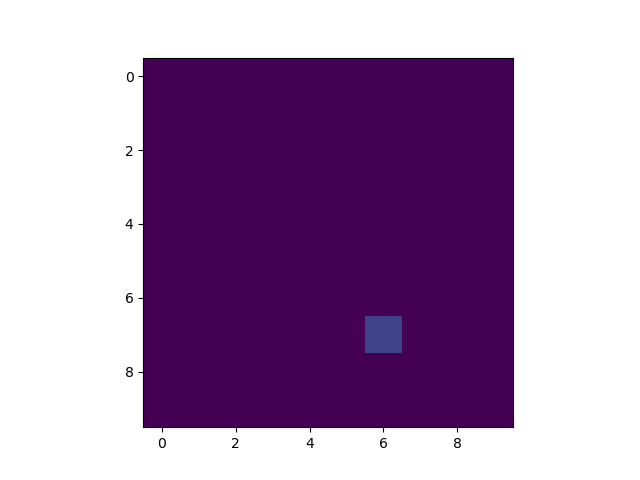

In [11]:
fig = plt.figure()
im = plt.imshow(momentum_object.render(), animated=True)
def updatefig(*args):
    position = torch.tensor([momentum_object.get_state_action()]).to(device)
    predict_position = encoder(position).cpu().detach().numpy()[0]
    momentum_object.step()
    im.set_array(momentum_object.render(predict_position))
ani = FuncAnimation(fig, updatefig, interval=500, blit=True)
# plt.show()

In [10]:
for i in range(100):
    momentum_object.step()
    position = torch.tensor([momentum_object.get_state_action()]).to(device)
    predict_position = encoder(position).cpu().detach().numpy()[0]
    print(predict_position)
    im.set_array(momentum_object.render(predict_position))

[0.99989771 0.76936865]
[0.96353125 0.67160851]
[0.89724227 0.67147141]
[0.77119219 0.6711651 ]
[0.77014911 0.55693823]
[0.55611583 0.32529832]
[0.55597464 0.32526446]
[0.32164272 0.32699519]
[0.43527096 0.32574755]
[0.55602211 0.32501891]
[0.43671023 0.22514227]
[0.4457642 0.110193 ]
[0.32904494 0.9991435 ]
[0.44018009 0.99019879]
[0.43995323 0.99014715]
[0.43995323 0.99014715]
[0.32564901 0.99014945]
[0.43370031 0.00382012]
[0.44558486 0.11052904]
[0.33303576 0.00247311]
[0.44810503 1.        ]
[0.2262158  0.88820255]
[0.32401082 0.7721383 ]
[0.22933378 0.67344814]
[0.23175572 0.43709529]
[0.32794304 0.22605561]
[0.33464876 0.11232607]
[0.33126836 0.00242148]
[0.44810503 1.        ]
[0.55872918 0.77143021]
[0.43599322 0.88779671]
[0.43769416 0.77212218]
[0.44032525 0.67214079]
[0.3260151  0.67307647]
[0.23122742 0.55511823]
[0.0013097  0.33116823]
[1.         0.33138632]
[0.67170247 0.43864389]
[0.55754912 0.43880582]
[0.32661393 0.22198879]
[0.32732766 0.22497006]
[0.22432116 0.0025